In [80]:
import os
import numpy as np
class UnetConfig(object):
    IMAGE_W = 64
    IMAGE_H = 64
    IMAGE_C = 1
    kernel_size=3
    n_levels = 4
    n_blocks=2
    pooling_size=2
    out_channels=1
    initial_features=32
    epochs = 50
    patch_size = 64
    batch_size = 64
 
    def displayConfiguration(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

In [86]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import os
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import math
import numpy as np
from keras.models import load_model



device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

class ResUNet(object):
    
    def __init__(self, config=UnetConfig()):
        self.config = config
        self.model = self.build_ResUNet()
    
    def normalizeImageIntensityRange(self,img):
      RANGE = np.max(img) - np.min(img)
      img[img < np.min(img)] = np.min(img)
      img[img > np.max(img)] = np.max(img)
      if( RANGE != 0):
        return (img - np.min(img)) /RANGE,1
      else:
        return img, 0

    def bn_act(self,x, act=True):
        x = keras.layers.BatchNormalization()(x)
        if act == True:
            x = keras.layers.Activation("relu")(x)
        return x

    def conv_block(self,x, filters, kernel_size=(3, 3), padding="same", strides=1):
        conv = ResUNet.bn_act(self, x)
        conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
        return conv

    def stem(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        conv = ResUNet.conv_block(self, conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
        
        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
        shortcut = ResUNet.bn_act(self, shortcut, act=False)
        
        output = keras.layers.Add()([conv, shortcut])
        return output

    def residual_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        res = ResUNet.conv_block(self, x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
        res = ResUNet.conv_block(self, res, filters, kernel_size=kernel_size, padding=padding, strides=1)
        
        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
        shortcut = ResUNet.bn_act(self, shortcut, act=False)
        
        output = keras.layers.Add()([shortcut, res])
        return output

    def upsample_concat_block(self, x, xskip):
        u = keras.layers.UpSampling2D((2, 2))(x)
        c = keras.layers.Concatenate()([u, xskip])
        return c
    def build_ResUNet(self):
        f = [16, 32, 64, 128, 256]
        inputs = keras.layers.Input((64, 64, 1))
        
        ## Encoder
        e0 = inputs
        e1 = ResUNet.stem(self, e0, f[0])
        e2 = ResUNet.residual_block(self, e1, f[1], strides=2)
        e3 = ResUNet.residual_block(self, e2, f[2], strides=2)
        e4 = ResUNet.residual_block(self, e3, f[3], strides=2)
        e5 = ResUNet.residual_block(self, e4, f[4], strides=2)
        
        ## Bridge
        b0 = ResUNet.conv_block(self, e5, f[4], strides=1)
        b1 = ResUNet.conv_block(self, b0, f[4], strides=1)
        
        ## Decoder
        u1 = ResUNet.upsample_concat_block(self, b1, e4)
        d1 = ResUNet.residual_block(self, u1, f[4])
        
        u2 = ResUNet.upsample_concat_block(self, d1, e3)
        d2 = ResUNet.residual_block(self, u2, f[3])
        
        u3 = ResUNet.upsample_concat_block(self, d2, e2)
        d3 = ResUNet.residual_block(self, u3, f[2])
        
        u4 = ResUNet.upsample_concat_block(self, d3, e1)
        d4 = ResUNet.residual_block(self, u4, f[1])
        
        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
        model = keras.models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

    def train(self):
        model = self.model
            
        img_patches = []
        mask_patches = []
        img_patches_val = []
        mask_patches_val = []
        patch_size = self.config.patch_size

        for cpt in range (13, len(os.listdir('/content/drive/My Drive/ds102_R2.0.0/')) ):

          ImagePath = f'/content/drive/My Drive/ds102_R2.0.0/sub-{cpt}/anat/sub-{cpt}_T1w_brain.nii.gz'
          MaskPath = f'/content/drive/My Drive/ds102_R2.0.0/sub-{cpt}/anat/sub-{cpt}_T1w_brain_pve_0.nii.gz' 
          
          Image = nib.load(ImagePath).get_fdata()
          Mask = nib.load(MaskPath).get_fdata()

          for i in range (0, Image.shape[1]):
              ImageSlice = Image[:,i,:]
              MaskSlice = Mask[:,i,:]
              ImageSliceResize= cv2.resize(ImageSlice, (256,256))
              MaskSliceResize = cv2.resize(MaskSlice, (256,256))
              
              I, flag = ResUNet.normalizeImageIntensityRange(self, ImageSliceResize)
              if flag!=0:
                ImageSliceResize = I
             
              M, flag =  ResUNet.normalizeImageIntensityRange(self, MaskSliceResize)
              if flag!=0:
                MaskSliceResize = M

              if cpt<24:

                for k in range (0, ImageSliceResize.shape[0], patch_size):
                  for j in range(0, ImageSliceResize.shape[1], patch_size):
                    patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    
                    if(np.max(patch_image)>0):
                      img_patches.append(patch_image)
                      mask_patches.append(patch_mask)

              else:
                for k in range (0, ImageSliceResize.shape[0], patch_size):
                  for j in range(0, ImageSliceResize.shape[1], patch_size):
                    patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
                    img_patches_val.append(patch_image)
                    mask_patches_val.append(patch_mask)

        X_train = np.zeros((len(mask_patches),patch_size,patch_size,1))
        Y_train = np.zeros((len(mask_patches),patch_size,patch_size,1))
        for i in range(0,len(mask_patches)):
          X_train[i,:,:,0] = img_patches[i]
          Y_train[i,:,:,0] = mask_patches[i]

        X_val = np.zeros((len(mask_patches_val),patch_size,patch_size,1))
        Y_val = np.zeros((len(mask_patches_val),patch_size,patch_size,1))
        for i in range(0,len(mask_patches_val)):
          X_val[i,:,:,0] = img_patches_val[i]
          Y_val[i,:,:,0] = mask_patches_val[i]

        with tf.device('/device:GPU:0'):
          model.fit(X_train, Y_train, epochs = self.config.epochs, batch_size = self.config.batch_size, validation_data = (X_val, Y_val))
    
    def save_model(self,name):
      return self.model.save(name)
    def load_data(self, ImagePath, MaskPath, slices):

      Image = nib.load(ImagePath).get_fdata()
      Mask = nib.load(MaskPath).get_fdata()

      ImageSlice = Image[:,slices,:]
      MaskSlice = Mask[:,slices,:]
      ImageSliceResize= cv2.resize(ImageSlice, (256,256))
      MaskSliceResize = cv2.resize(MaskSlice, (256,256))
      return ImageSliceResize, MaskSliceResize

    def predict(self,ImagePath, MaskPath, slices, modelpath, load_model1 = False):

        ImageSliceResize, MaskSliceResize = ResUNet.load_data(self,ImagePath, MaskPath, slices)

        I, flag =  ResUNet.normalizeImageIntensityRange(self, ImageSliceResize)
        if flag!=0:
          ImageSliceResize = I
        
        img_patches = []
        mask_patches = []
        patch_size = self.config.patch_size

        for k in range (0, ImageSliceResize.shape[0], patch_size):
          for j in range(0, ImageSliceResize.shape[1], patch_size):
            patch_image = cv2.resize(ImageSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
            patch_mask = cv2.resize(MaskSliceResize[k:k+patch_size, j:j+patch_size], (patch_size, patch_size))
            img_patches.append(patch_image)
            mask_patches.append(patch_mask)

        X_test = np.zeros((len(mask_patches),patch_size,patch_size,1))
        Y_test = np.zeros((len(mask_patches),patch_size,patch_size,1))

        for i in range(0,len(mask_patches)):
          X_test[i,:,:,0] = img_patches[i]
          Y_test[i,:,:,0] = mask_patches[i]

        if (load_model1 == False):
          result=self.model.predict(X_test)
        else:
          model2 = load_model( modelpath)
          result=model2.predict(X_test)
        return result,img_patches, mask_patches

    def show_predict(self,ImagePath, MaskPath, slices, num_patch,  modelpath, load_model1 = False, rgb_gray = False):
      Y_prediction,img_patches, mask_patches = ResUNet.predict(self, ImagePath, MaskPath, slices, modelpath, load_model1)
      final_pred = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred = Y_prediction[:,:,:,0]
      final_pred[final_pred>0.5] = 1
      title = ["Input patch", "True Mask", "Mask Predicted"]
      
      if rgb_gray:
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title(title[0],fontdict = {'fontsize' : 18})
        plt.imshow(img_patches[num_patch], cmap = 'gray')
        plt.subplot(1,3,2)
        plt.title(title[1],fontdict = {'fontsize' : 18})
        plt.imshow(mask_patches[num_patch], cmap = 'gray')
        plt.subplot(1,3,3)
        plt.title(title[2],fontdict = {'fontsize' : 18})
        plt.imshow(final_pred[num_patch], cmap = 'gray')
        plt.show()
      else : 
        rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
        rgb[mask_patches[num_patch]>0.5] = (0,0,1)

        pred_rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
        pred_rgb[final_pred[num_patch]>0.5] = (0,0, 1)

        title = ["Input patch", "True Mask", "Mask Predicted"]
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title(title[0],fontdict = {'fontsize' : 18})
        plt.imshow(img_patches[num_patch], cmap = 'gray')
        plt.subplot(1,3,2)
        plt.title(title[1],fontdict = {'fontsize' : 18})
        plt.imshow(rgb, cmap = 'gray')
        plt.subplot(1,3,3)
        plt.title(title[2],fontdict = {'fontsize' : 18})
        plt.imshow(pred_rgb, cmap = 'gray')
        plt.show()
        ResUNet.get_f1(self, rgb, pred_rgb)
      return rgb, pred_rgb

    def show_predict_3classes(self,ImagePath, MaskPath, MaskPath1, MaskPath2, slices, num_patch,  modelpath_csf, modelpath_gm, modelpath_wm, showprint =False):

      Y_prediction_csf,img_patches, mask_patches_csf = ResUNet.predict(self, ImagePath, MaskPath, slices,  modelpath_csf, True)
      Y_prediction_gm,img_patches, mask_patches_gm = ResUNet.predict(self, ImagePath, MaskPath1, slices,  modelpath_gm, True)
      Y_prediction_wm,img_patches, mask_patches_wm = ResUNet.predict(self, ImagePath, MaskPath2, slices,  modelpath_wm, True)

      final_pred_csf = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_csf = Y_prediction_csf[:,:,:,0]

      final_pred_gm = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_gm = Y_prediction_gm[:,:,:,0]

      final_pred_wm = np.zeros((16,self.config.patch_size,self.config.patch_size))
      final_pred_wm = Y_prediction_wm[:,:,:,0]

      rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
      rgb[mask_patches_csf[num_patch]>0.5] = (1,0,0)
      rgb[mask_patches_gm[num_patch]>0.5] = (0,1,0)
      rgb[mask_patches_wm[num_patch]>0.5] = (0,0,1)

      pred_rgb = np.zeros((self.config.patch_size,self.config.patch_size,3))
      pred_rgb[final_pred_wm[num_patch]>0.5] = (1,0,0)
      pred_rgb[final_pred_csf[num_patch]>0.5] = (0,1,0)
      pred_rgb[final_pred_gm[num_patch]>0.5] = (0,0, 1)
      if showprint:
        title = ["Input patch", "True Mask", "Mask Predicted"]
        plt.figure(figsize = (10,10))
        plt.subplot(1,3,1)
        plt.title(title[0],fontdict = {'fontsize' : 18})
        plt.imshow(img_patches[num_patch], cmap = 'gray')
        plt.subplot(1,3,2)
        plt.title(title[1],fontdict = {'fontsize' : 18})
        plt.imshow(rgb, cmap = 'gray')
        plt.subplot(1,3,3)
        plt.title(title[2],fontdict = {'fontsize' : 18})
        plt.imshow(pred_rgb, cmap = 'gray')
        plt.show()
        ResUNet.get_f1(self, rgb, pred_rgb)
      return final_pred_csf, final_pred_wm, final_pred_gm
    
    def get_f1(self, y_true, y_pred): #taken from old keras source code
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      recall = true_positives / (possible_positives + K.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
      print(f1_val)
      return f1_val

    def reconstruction(self, final_pred, showprint = False ):
      pred_rec = np.zeros((256,256))
      cpt = 0
      for i in range(1,5):
        for j in range(1,5):
          pred_rec[64*(i-1):64*i,64*(j-1):64*j] = final_pred[cpt]
          cpt = cpt +1
      if showprint : 
        plt.figure(figsize=(10,10))
        plt.imshow(pred_rec, cmap ='gray')
        plt.show()
      return pred_rec

    def rgb(self, MaskPath, MaskPath1, MaskPath2, slices, modelpath_csf, modelpath_gm, modelpath_wm, ImagePath):
      
      f1,f2,f3 = ResUNet.show_predict_3classes(self,ImagePath, MaskPath, MaskPath1, MaskPath2, slices, 5,  modelpath_csf, modelpath_gm, modelpath_wm, showprint = False)
      t1 =  ResUNet.reconstruction(self, f1, showprint = False)
      t2 =  ResUNet.reconstruction(self,f2, showprint = False)
      t3 = ResUNet.reconstruction(self,f3, showprint = False)
      
      Image = nib.load(ImagePath).get_fdata()
      Mask = nib.load(MaskPath).get_fdata()
      Mask1 = nib.load(MaskPath1).get_fdata()
      Mask2 = nib.load(MaskPath2).get_fdata()
      ImageSlice = Image[:,slices,:]
      MaskSlice = Mask[:,slices,:]
      MaskSlice1 = Mask1[:,slices,:]
      MaskSlice2 = Mask2[:,slices,:]
      ImageSliceResize= cv2.resize(ImageSlice, (256,256))
      MaskSliceResize = cv2.resize(MaskSlice, (256,256))
      MaskSliceResize1 = cv2.resize(MaskSlice1, (256,256))
      MaskSliceResize2 = cv2.resize(MaskSlice2, (256,256))


      fin = np.zeros((256,256,3))
      fin[t1>0.5] = (1,0,0)
      fin[t2>0.5] = (0,1,0)
      fin[t3>0.5] = (0,0,1)

      fin1 = np.zeros((256,256,3))
      fin1[MaskSliceResize2>0.5] = (1,0,0)
      fin1[MaskSliceResize>0.5] = (0,1,0)
      fin1[MaskSliceResize1>0.5] = (0,0,1)


      plt.figure(figsize = (20,20))
      plt.subplot(1,3,1)
      plt.title("INPUT IMAGE",fontdict = {'fontsize' : 18})
      plt.imshow(ImageSliceResize, cmap = 'gray')
      plt.subplot(1,3,2)
      plt.title("TRUE MASK",fontdict = {'fontsize' : 18})
      plt.imshow(fin)
      plt.subplot(1,3,3)
      plt.title("PREDICTED MASK",fontdict = {'fontsize' : 18})
      plt.imshow(fin1)

      unet.get_f1(fin,fin1)
      plt.show()

      fin = cv2.resize(fin, (256,176))
      fin1 = cv2.resize(fin1, (256,176))
      ImageSlice = cv2.resize(ImageSlice, (256,176))
      plt.figure(figsize=(20,20))
      plt.subplot(1,3,1)
      plt.title("INPUT IMAGE",fontdict = {'fontsize' : 18})
      plt.imshow(ImageSlice, cmap = 'gray')
      plt.subplot(1,3,2)
      plt.title("TRUE MASK",fontdict = {'fontsize' : 18})
      plt.imshow(fin)
      plt.subplot(1,3,3)
      plt.title("PREDICTED MASK",fontdict = {'fontsize' : 18})
      plt.imshow(fin1)
      plt.show()
            
      unet.get_f1(fin,fin1)






Found GPU at: /device:GPU:0


In [ ]:
config=UnetConfig()

resunet=ResUNet(config=config)

resunet.train()
resunet.save_model('/content/drive/My Drive/res_u_class_pve0_100.h5')

In [82]:
config=UnetConfig()

unet=ResUNet(config=config)

Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_870 (Conv2D)             (None, 64, 64, 16)   160         input_30[0][0]                   
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 64, 64, 16)   64          conv2d_870[0][0]                 
__________________________________________________________________________________________________
activation_551 (Activation)     (None, 64, 64, 16)   0           batch_normalization_812[0][0]    
______________________________________________________________________________________

In [83]:
ImagePath = '/content/drive/My Drive/sub-04_T1w_brain.nii'
MaskPath = '/content/drive/My Drive/sub-04_T1w_brain_pve_2.nii.gz' 
MaskPath1 = '/content/drive/My Drive/sub-04_T1w_brain_pve_1.nii.gz' 
MaskPath2 = '/content/drive/My Drive/sub-04_T1w_brain_pve_0.nii' 


ImagePath = '/content/drive/My Drive/0050458/001_brain.nii.gz'
MaskPath = '/content/drive/My Drive/0050458/001_brain_pve_2.nii.gz' 
MaskPath1 = '/content/drive/My Drive/0050458/001_brain_pve_1.nii.gz' 
MaskPath2 = '/content/drive/My Drive/0050458/001_brain_pve_0.nii.gz'


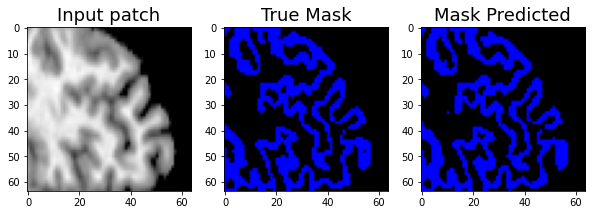

tf.Tensor(0.956554827976601, shape=(), dtype=float64)


In [84]:
Y_prediction = unet.show_predict(ImagePath, MaskPath1,100,6,'/content/drive/My Drive/model_resunet_class_pve1_100.h5', True)


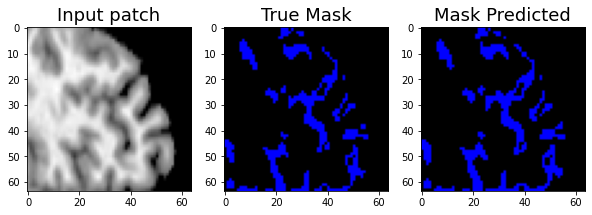

tf.Tensor(0.9353740996582758, shape=(), dtype=float64)


In [ ]:
Y_prediction = unet.show_predict(ImagePath, MaskPath2,100,6,'/content/drive/My Drive/model_resunet_class_pve0_100.h5', True)

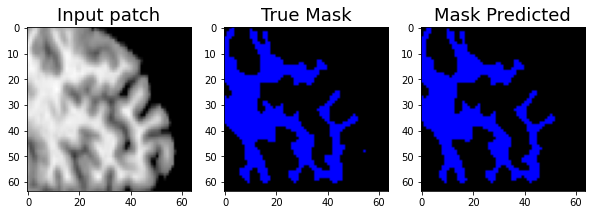

tf.Tensor(0.9799999499244637, shape=(), dtype=float64)


In [ ]:
Y_prediction = unet.show_predict(ImagePath, MaskPath,100,6,'/content/drive/My Drive/model_resunet_class_pve2_100.h5', True)

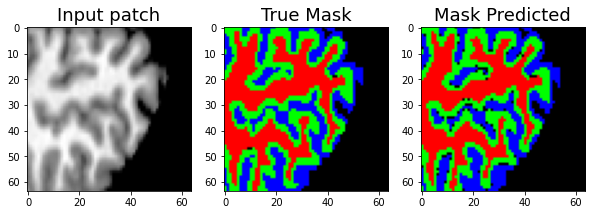

tf.Tensor(0.9522292493388872, shape=(), dtype=float64)


In [ ]:
fp1,fp2,fp3 = unet.show_predict_3classes(ImagePath, MaskPath, MaskPath1, MaskPath2, 105, 10,  '/content/drive/My Drive/model_resunet_class_pve1_100.h5','/content/drive/My Drive/model_resunet_class_pve0_100.h5','/content/drive/My Drive/model_resunet_class_pve2_100.h5',showprint = True )


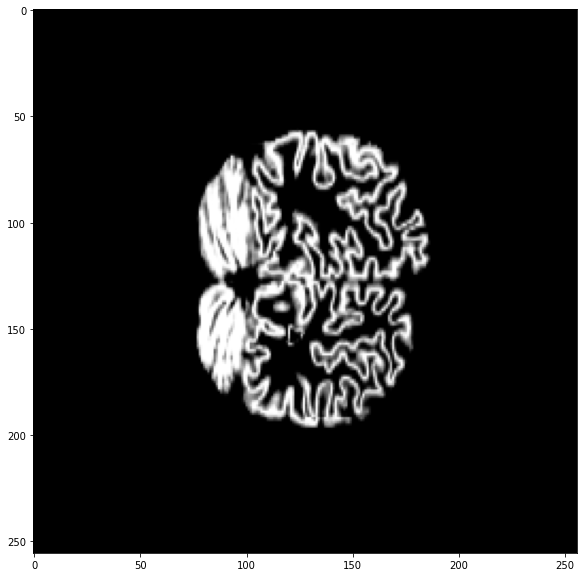

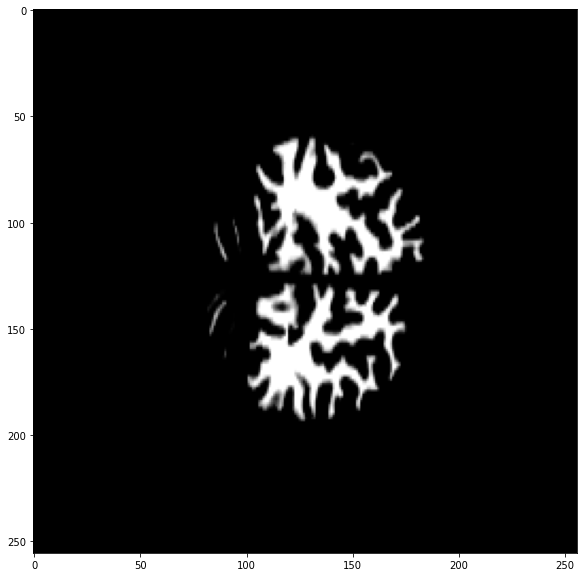

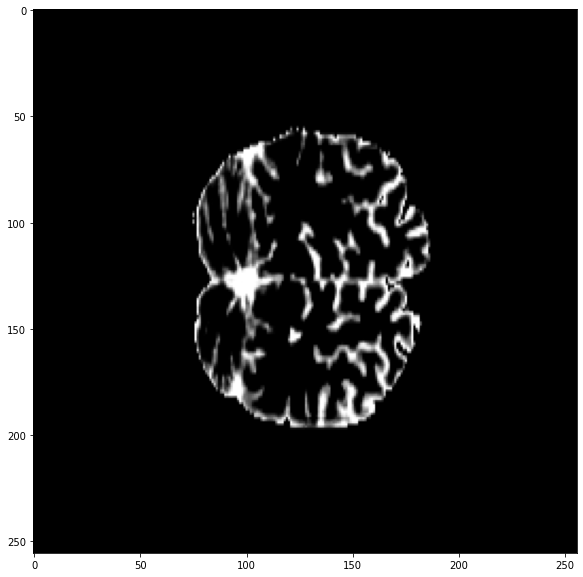

In [ ]:
t1 = unet.reconstruction(fp1,showprint= True)
t2 = unet.reconstruction(fp2,showprint= True)
t3 =unet.reconstruction(fp3,showprint= True)

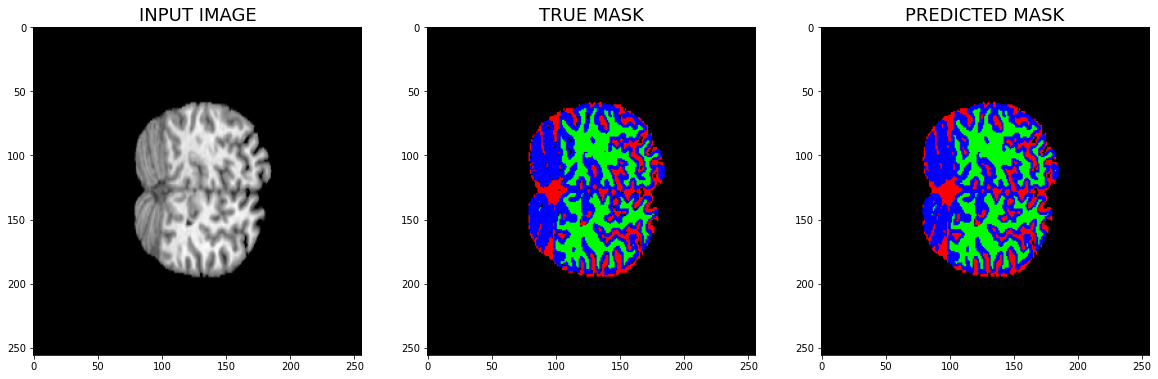

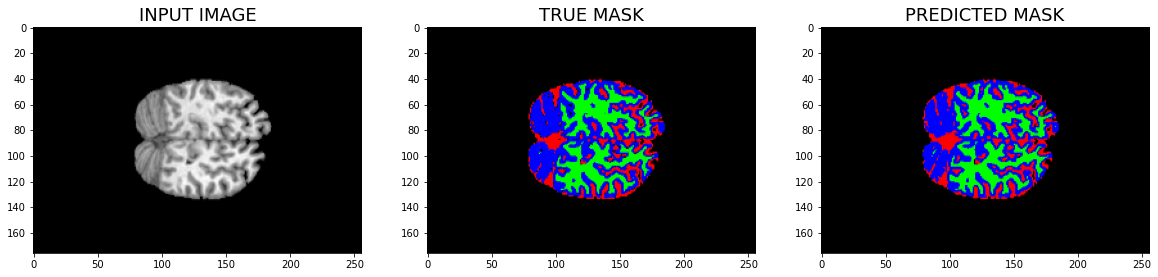

tf.Tensor(0.9086995717477762, shape=(), dtype=float64)


In [87]:

unet.rgb(MaskPath, MaskPath1, MaskPath2,100, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)

tf.Tensor(0.9553425004609842, shape=(), dtype=float64)


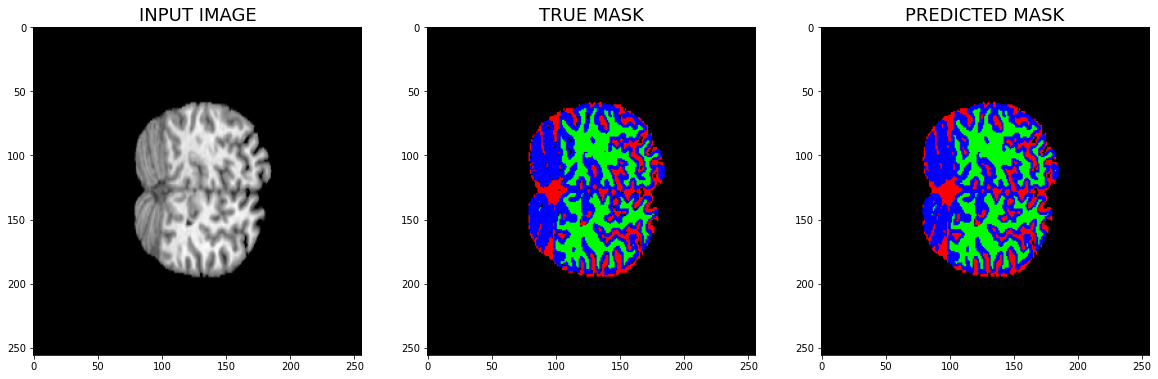

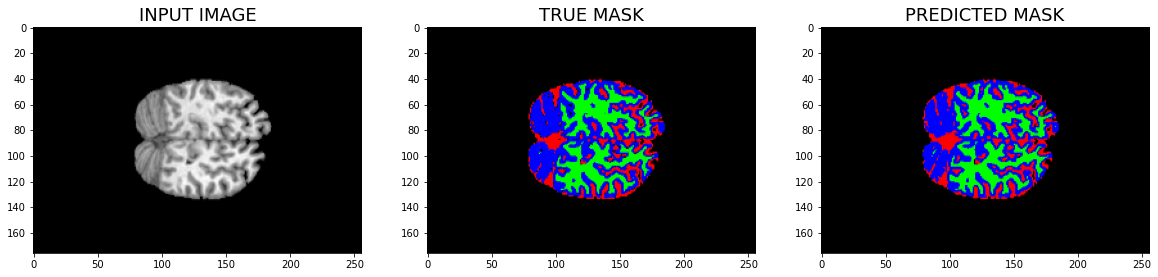

tf.Tensor(0.9086995717477762, shape=(), dtype=float64)


In [ ]:
unet.rgb(MaskPath, MaskPath1, MaskPath2,100, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,90, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,80, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,70, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,60, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,50, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,40, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)
unet.rgb(MaskPath, MaskPath1, MaskPath2,110, '/content/drive/My Drive/model_resunet_class_pve0_100.h5', '/content/drive/My Drive/model_resunet_class_pve1_100.h5', '/content/drive/My Drive/model_resunet_class_pve2_100.h5', ImagePath)